# Wingsail Controller Prototype

In [19]:
# Install Python dependencies
!pip3 install numpy scipy matplotlib
!sudo apt update && sudo apt install -y ffmpeg

Defaulting to user installation because normal site-packages is not writeable
Hit:1 http://packages.ros.org/ros2/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease    
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease              
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Ign:5 http://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 Release
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
267 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://repo.mongodb.org/apt/ubuntu/dists/jammy/mongodb-org/6.0/Release.gpg: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Reading package lists... Done
Building dependency tree... Done
Reading state informa

In [20]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Function `compute_reynolds_number` Implementation

It takes the apparent wind speed and the chord width to computes the Reynold's number. 

$$Re = \frac{V_{app}c}{k}$$

where $V_{app}$ is the apparent wind speed, $c$ is the chord width of the mainsail, and $k$ is the kinematic viscosity of air. The kinematic viscosity is a constant value of $1.5 \times 10^{-5} \frac{m^2}{s}$, and the chord width is a constant value of $14 cm$ obtained from mech's design.

```python

In [21]:
CHORD_WIDTH_MAIN_SAIL = 0.14  # meters, trim tab chord width is not included
KINEMATIC_VISCOSITY = 0.000014207  # {m^2 / s at 10degC} and air density at 1.225 {kg / m^3}


def compute_reynolds_number(apparent_wind_speed):
    """
    Computes the Reynolds number for the main sail.

    Parameters:
    - apparent_wind_speed (float): The apparent wind speed in meters per second.

    Returns:
    - reynolds_number (float): The computed Reynolds number for the main sail.
    """
    reynolds_number = (apparent_wind_speed * CHORD_WIDTH_MAIN_SAIL) / KINEMATIC_VISCOSITY
    return reynolds_number

## Function `compute_angle_of_attack` Implementation

It takes the Reynolds number and uses a lookup table to find the angle of attack.

In [22]:
def compute_angle_of_attack(reynolds_number, look_up_table):
    """
    Computes the desired angle of attack based on Reynolds number and a lookup table.

    Parameters:
    - reynolds_number (float): The Reynolds number.
    - look_up_table: A 2D numpy array containing Reynolds numbers in the first column
      and corresponding desired angles of attack in the second column.

    Returns:
    - desired_alpha (float): The computed desired angle of attack based on the provided Reynolds number
      and lookup table.
    """
    desired_alpha = np.interp(reynolds_number, look_up_table[:, 0], look_up_table[:, 1])
    return desired_alpha

## Function `compute_trim_tab_angle` Implementation

It takes the desired alpha value and computes the resulting trim tab angle. 

Computes the trim tab angle based on the desired angle of attack and the apparent wind direction. `apparent_wind_direction` will use degrees and follow same convention of WindSensor.msg (positive angle mean CW rotation). Zero degrees means that the apparent wind is blowing from the bow to the stern of the boat. 

The reason that the trim tab is equal to the `desired_alpha` mirrored about the apparent wind direction is because the the wind will push the trim tab, effectively rotating the mainsail until the trim tab is in line with the apparent wind (The mainsail sits on a bearing and will not rotate unless the trim tab is being pushed by the wind). This means that if we want to rotate the mainsail x degrees, we need to rotate the trim tab -x degrees. 

In [23]:
def compute_trim_tab_angle(desired_alpha, apparent_wind_direction):
    """
    Range: -180 < direction <= 180 for symmetry

    Parameters:
    - desired_alpha (float): The desired angle of attack.
    - apparent_wind_direction (float): The apparent wind direction in degrees.

    Returns:
    - trim_tab_angle (float): The computed trim tab angle based on the provided desired angle of attack,
      apparent wind direction, and boat direction.

    """
    return math.copysign(desired_alpha, apparent_wind_direction)

## Test `test_trim_tab_angle`:

Takes in apparent wind speed, apparent wind direction and the look up table of reynolds values and angles of attack. It then computes the reynolds number, followed by the and the angle of attack (alpha value). It then computes the trim tab angle and prints it.


In [24]:
def test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table):
    """_summary_

    Parameters:
        apparent_wind_speed (float): the apparent wind speed of the boat
        apparent_wind_direction (float): apparent wind direction in degrees
        look_up_table (float, float): a 2D array containing Reynolds numbers in the first column
        and corresponding desired angles of attack in the second column
    """
    reynolds = compute_reynolds_number(apparent_wind_speed)
    alpha = compute_angle_of_attack(reynolds, look_up_table)
    trim_tab_angle = compute_trim_tab_angle(alpha, apparent_wind_direction)

    print("Reynolds number: ", round(reynolds, 2))
    print("Angle of attack: ", round(alpha, 2))
    print("Trim tab angle: ", round(trim_tab_angle, 2))

## Reynolds to Alpha Lookup Table
`lookup_table` is a table that pairs reynolds numbers with angles of attack. The reynolds numbers are the keys and the angles of attack are the values. This table is sourced from [MECH testing](https://docs.google.com/spreadsheets/d/1rQuq55-VvUJRCS3mtuV4XycXq11VGx2vdJTXsl3EVNs/edit#gid=0) and is likely more accurate then the computations that would be done instead.

| Reynolds Number | Angle of Attack |
|-----------------|-----------------|
| 50,000          | 5.75            |
| 100,000         | 6.75            |
| 200,000         | 7.00            |
| 500,000         | 9.75            |
| 1,000,000       | 10.00           |

## Different Apparent Wind Speeds and Apparent Wind Directions as Inputs

The following tests print the trim tab angle, Reynolds number, and angle of attack based on the provided inputs.


In [25]:
apparent_wind_speed = 14.2  # m/s
apparent_wind_direction = -23  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table)

Reynolds number:  139931.02
Angle of attack:  6.85
Trim tab angle:  -6.85


In [26]:
apparent_wind_speed = 100  # m/s
apparent_wind_direction = 40  # degrees
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # reynolds number, angle of attack

test_trim_tab_angle(apparent_wind_speed, apparent_wind_direction, look_up_table)

Reynolds number:  985429.72
Angle of attack:  9.99
Trim tab angle:  9.99


## Boat Diagram

### Function definitions
`angle` and `windDirection` parameters are values given in degrees and uses left hand coordinate system where positive 
angles represent clockwise rotation on the plot.

`point` and `center` are 2 element arrays that represent a point on an XY cartesian plane. The plot used has the origin
of the cartesian plane in the middle of the plot. Rhe x and y axis are the horizontal and vertical axises respectively.
The first element represents the x value of the point while the second element represents the y value of the point.

`obj` and `sail` are arrays of points (2 element arrays). These arrays represent objects that will be drawn on the plot.
These arrays are iterated over and have a line from one point element to the next point element. The `sail` array has
two sections, the main sail and the trim tab. The trim tab is represented by the last two points of the `sail` array.
This convention is why the method `rotate_trimtab` exists. 

In [27]:
def rotatePointAroundPoint(point, center, angle):
    """
    Returns a point represented by 2 element array (e.g. [x, y]) rotated around a center point
    by angle in degrees. Rotation is done by translating point using center:
    `translated_point` = `point` - `center`

    then applies the rotation matrix:
    `rotated_translated_point` = `rotation_matrix` @ `translated_point`

    then translating the rotated point by center
    `rotated_point` = `rotated_translated_point` + `center`

    Parameters:
        point (array): Point that will be rotated.
        center (array): point used as center of rotation for point.
        angle (float): angle in degrees to rotate point.

    Returns:
        rotated_point (array): Point that has been rotated.
    """

    point = np.array(point)
    center = np.array(center)

    angle = math.radians(angle)

    rotation_matrix = np.array(
        [[np.cos(angle), np.sin(angle)], [-1 * np.sin(angle), np.cos(angle)]]
    )

    translated_point = point - center
    rotated_point = rotation_matrix @ translated_point
    rotated_point = rotated_point + center

    return rotated_point


def rotate_object_around_origin(obj, angle):
    """
    Returns an object, represented by an array of points, with each point rotated around the
    origin by angle degrees.

    Parameters:
        obj (array): Array of points that represents an object.
        angle (float): angle in degrees to rotate object.

    Returns:
        obj (array): Array of points that represents an object, reach point rotated around the
        origin.
    """
    for i in range(len(obj)):
        obj[i] = rotatePointAroundPoint(obj[i], [0, 0], angle)
    return obj


def rotate_trimtab(sail, angle):
    """
    Returns an sail object, represented by an array of points, with the last point rotated around
    the second to last point by angle degrees.

    Parameters:
        sail (array): Array of points that represents a sail object.
        angle (float): angle in degrees to rotate last point of sail object.

    Returns:
        sail (array): Array of points that represents a sail object, with the last point rotated
        around the second to last point.
    """
    sail[-1] = rotatePointAroundPoint(sail[-1], sail[-2], angle)
    return sail


def drawWind(windDirection):
    """
    Draws a wind arrow on a plot using the given wind angle in degrees following WindSensor.msg
    convention.

    Parameters:
        windDirection (float): Wind direction given in angles

    Returns:
        none
    """
    windTail = [0, 3]
    windTail = rotatePointAroundPoint(windTail, [0, 0], windDirection)
    windHead = [0, -2]
    windHead = rotatePointAroundPoint(windHead, [0, 0], windDirection)
    plt.arrow(
        windTail[0],
        windTail[1],
        windHead[0],
        windHead[1],
        head_width=0.2,
        head_length=0.3,
        fc="black",
        ec="black",
        label="wind",
    )


def drawWindField(windDirection, ax=None):
    """
    Draws a wind field on a plot using the given wind angle in degrees following WindSensor.msg
    convention.

    Args:
         windDirection (float): Wind direction given in angles
    """
    if ax is None:
        ax = plt.gca()

    x = np.linspace(-7, 7, 15)
    y = np.linspace(-7, 7, 15)
    X, Y = np.meshgrid(x, y)
    U = np.sin(np.radians(windDirection)) * np.ones_like(X)
    V = -1 * np.cos(np.radians(windDirection)) * np.ones_like(Y)
    ax.quiver(X, Y, U, V, alpha=0.5, width=0.003, label="Wind Field")


def drawBoat():
    """
    Draws a boat on a plot with the bow of the boat pointing in the +y direction.

    Returns:
        none
    """
    boat = [[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]
    x_values = []
    y_values = []
    for i in range(len(boat)):
        x_values.append(boat[i][0])
        y_values.append(boat[i][1])

    plt.plot(x_values, y_values, color="red", alpha=0.9)


def drawSail(sail):
    """
    Draws a sail on the plot using the points contained in the sail object (array of points).

    Parameters:
        sail (array):Array of points that represents a sail object.

    Returns:
        none
    """
    x_values = []
    y_values = []
    for i in range(len(sail)):
        x_values.append(sail[i][0])
        y_values.append(sail[i][1])

    plt.plot(x_values[0:-3], y_values[0:-3], color="blue", label="mainsail")
    plt.plot(x_values[-4:-2], y_values[-4:-2], color="black", linestyle="dotted")
    plt.plot(x_values[-2:], y_values[-2:], color="green", label="trimtab")


def drawValues(windSpeed, windDirection, angleOfAttack, trimTabAngle, ax=None):
    """
    Prints out inputs for controller onto top right of plot.

    Args:
        windSpeed (float): Wind speed given in m/s
        windDirection (float): Wind direction given in angles
        angleOfAttack (float): Angle of attack given in degrees
        trimTabAngle (float): Trim tab angle given in degrees
    """
    if ax is None:
        ax = plt.gca()

    values = (
        f"Wind Speed: {windSpeed:.2f} m/s\n"
        + f"Wind Direction: {windDirection:.2f} degrees\n"
        + f"Angle of Attack: {angleOfAttack:.2f} degrees\n"
        + f"Trim Tab Angle: {trimTabAngle:.2f} degrees"
    )

    ax.text(
        0,
        0,
        values,
        horizontalalignment="center",
        verticalalignment="center",
        bbox=dict(facecolor="white", alpha=0.0),
        fontsize=8,
    )


def drawVectors(windDirection, sail_angle, ax=None):
    if ax is None:
        ax = plt.gca()

    base_point = np.array([0, -1])
    windDirection = math.radians(windDirection)
    sail_angle = math.radians(sail_angle)
    rotation_matrix_wind = np.array(
        [
            [np.cos(windDirection), -np.sin(windDirection)],
            [np.sin(windDirection), np.cos(windDirection)],
        ]
    )
    rotation_matrix_sail = np.array(
        [[np.cos(sail_angle), -np.sin(sail_angle)], [np.sin(sail_angle), np.cos(sail_angle)]]
    )
    wind_vector = rotation_matrix_wind @ base_point
    sail_vector = rotation_matrix_sail @ base_point

    ax.quiver(
        0,
        0,
        wind_vector[0],
        wind_vector[1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="blue",
        label="Wind Vector",
    )
    ax.quiver(
        0,
        0,
        sail_vector[0],
        sail_vector[1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="green",
        label="Sail Vector",
    )

    angle_of_attack = windDirection - sail_angle

    ax.text(
        -1.75,
        -1.5,
        f"Angle between Vectors: {math.degrees(abs(angle_of_attack)):.2f} deg",
        fontsize=8,
        bbox=dict(facecolor="white", alpha=1.0),
    )


def showPlot():
    """
    Prints out the plot.

    Returns:
        none
    """
    plt.xlim(-7, 7)
    plt.ylim(-5, 5)
    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xticks([])
    plt.yticks([])

    plt.title("Wingsail Controller Visualization")

    plt.legend(loc="upper left")
    plt.show()


def randomizeWindDirection(size):
    """Generates a series of wind directions randomly within the range [-180, 180].

    Args:
        size (int): The number of random wind directions to generate.

    Returns:
        list: A list containing the randomly generated wind directions.
    """
    series = []
    random_numbers = [int(random.uniform(-180, 180)) for _ in range(size)]
    for i in range(1, len(random_numbers), 1):
        step = 1
        if random_numbers[i - 1] > random_numbers[i]:
            step = -1
        series = series + list(range(random_numbers[i - 1], random_numbers[i], step))

    return series


def preventInIrons(trim_tab_angle, apparent_wind_direction):
    """Adjusts the trim tab angle based on the apparent wind direction.

    If the apparent wind direction is within -45 to 45 degrees, the trim tab angle is set to 0.
    Otherwise, the trim tab angle remains unchanged.

    Args:
        trim_tab_angle (float): The current angle of the trim tab.
        apparent_wind_direction (float): The direction of the apparent wind in degrees.

    Returns:
        float: The adjusted trim tab angle.
    """

    if apparent_wind_direction > -45 and apparent_wind_direction < 45:
        return 0
    else:
        return trim_tab_angle

### Diagram Construction
The fun section! 
1. Input wind speed and wind direction in Input section 
2. then press "exceute cell and below" to draw plot

#### Input section

In [28]:
# input section
apparent_wind_speed = 100  # m/s
wind_direction = 50  # degrees, follows WindSensor.msg convention
look_up_table = np.array(
    [[50000, 5.75], [100000, 6.75], [200000, 7], [500000, 9.75], [1000000, 10]]
)  # [reynolds number, angle of attack(degrees)]

#### Drawing section

Wind speed:  100  m/s
Wind direction:  50  degrees
Reynolds number:  985429.72
Angle of attack:  9.99  degrees
Trim tab angle:  9.99  degrees


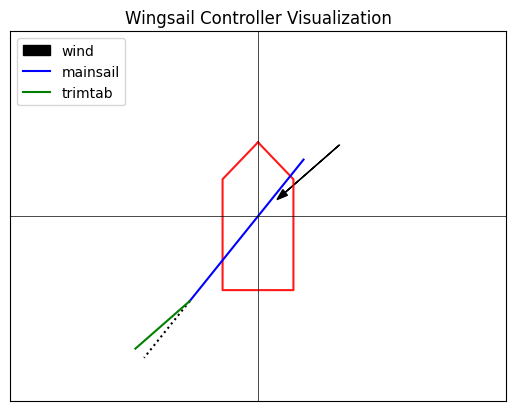

In [29]:
# Determine trimtab angle
reynolds = compute_reynolds_number(apparent_wind_speed)
a = compute_angle_of_attack(reynolds, look_up_table)
t = compute_trim_tab_angle(a, wind_direction)

# print functions
print("Wind speed: ", apparent_wind_speed, " m/s")
print("Wind direction: ", wind_direction, " degrees")
print("Reynolds number: ", round(reynolds, 2))
print("Angle of attack: ", round(a, 2), " degrees")
print("Trim tab angle: ", round(t, 2), " degrees")

# construction and manipulation of wingsail
wingsail = [[0, 2], [0, 0], [0, -3], [0, -5], [0, -3], [0, -5]]
wingsail = rotate_object_around_origin(wingsail, wind_direction)
wingsail = rotate_trimtab(wingsail, t)
wingsail = rotate_object_around_origin(wingsail, -t)

# Drawing commands
drawWind(wind_direction)
drawBoat()
drawSail(wingsail)
showPlot()

#### Animation section

The following section of this notebook creates a visualization of the wingsail controller in action. In particular,
the animation shows how the trim tab angle changes with apparent wind velocity.

The animation consists of a subplot. On the left-hand side, the boat and wingsail are animated as apparent wind
velocity changes. On the right-hand side, there are two plots. The first contains the visualization data over time,
and the second compares the main sail and wind vectors. Then angle between these two vectors represent the angle of
attack that is achieved by the wingsail controller.

In [30]:
class Shape2D:
    def __init__(self, points):
        self.points = np.array(points)

    def scale(self, scalar):
        return Shape2D(scalar * self.points)

    def translate(self, translation):
        return Shape2D(self.points + translation)

    def rotate(self, theta, centroid):
        theta = np.radians(theta)
        rotation_matrix = np.array(
            [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
        )
        points = (self.points - centroid) @ rotation_matrix + centroid
        return Shape2D(points)

    def plot(self, ax=None):
        if ax is None:
            ax = plt.gca()
        x = self.points[:, 0]
        y = self.points[:, 1]
        ax.plot(x, y, color="black")

    @staticmethod
    def plot_shapes(ax, *args):
        for shape in args:
            shape.plot(ax)


def get_symmetric_air_foil_points():
    y = 0.2 - np.array(
        [
            1.0,
            0.95,
            0.9,
            0.8,
            0.7,
            0.6,
            0.5,
            0.4,
            0.3,
            0.25,
            0.2,
            0.15,
            0.1,
            0.075,
            0.05,
            0.025,
            0.0125,
            0.005,
            0.0,
            0.005,
            0.0125,
            0.025,
            0.05,
            0.075,
            0.1,
            0.15,
            0.2,
            0.25,
            0.3,
            0.4,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            0.95,
            1.0,
        ]
    )
    x = 2.5 * np.array(
        [
            0.00095,
            0.00605,
            0.01086,
            0.01967,
            0.02748,
            0.03423,
            0.03971,
            0.04352,
            0.04501,
            0.04456,
            0.04303,
            0.04009,
            0.03512,
            0.0315,
            0.02666,
            0.01961,
            0.0142,
            0.0089,
            0.0,
            -0.0089,
            -0.0142,
            -0.01961,
            -0.02666,
            -0.0315,
            -0.03512,
            -0.04009,
            -0.04303,
            -0.04456,
            -0.04501,
            -0.04352,
            -0.03971,
            -0.03423,
            -0.02748,
            -0.01967,
            -0.01086,
            -0.00605,
            -0.00095,
        ]
    )
    return np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))

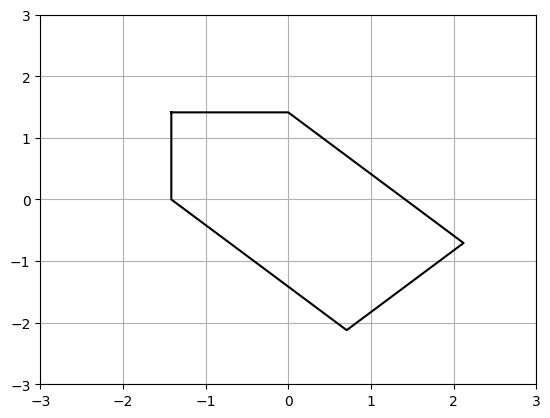

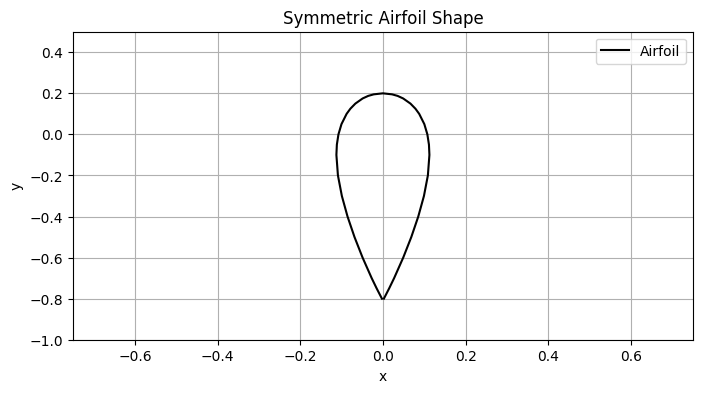

In [33]:
# Testing: Draw a boat and rotate it 45 degrees
boat = Shape2D(np.array([[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]))
boat.rotate(45, np.array([0, 0])).plot()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)

# Testing: Plot the airfoil
airfoil_points = get_symmetric_air_foil_points()
x_Coordinates = airfoil_points[:, 0]
y_Coordinates = airfoil_points[:, 1]

plt.figure(figsize=(8, 4))
plt.plot(x_Coordinates, y_Coordinates, label="Airfoil", color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.75, 0.75)
plt.ylim(-1.00, 0.50)
plt.title("Symmetric Airfoil Shape")
plt.grid(True)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Boat with Main Sail and Trim Tab Example')

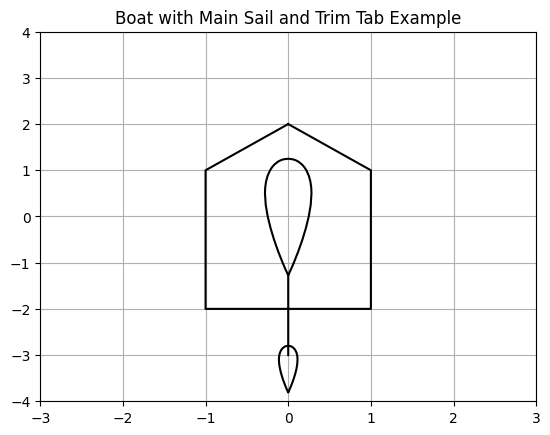

In [34]:
# Define basic shapes

# Boat shape
boat = Shape2D(np.array([[0, 2], [-1, 1], [-1, -2], [1, -2], [1, 1], [0, 2]]))

# Main sail and trim tab shapes
airfoil_points = get_symmetric_air_foil_points()
main_sail_points = np.vstack((airfoil_points, np.array([[0, -0.8], [0, -1.5]])))
trim_tab_points = airfoil_points

main_sail = Shape2D(main_sail_points).scale(2.5).translate([0, 0.75])
trim_tab = Shape2D(trim_tab_points)

# Testing: Plot the boat, main sail, and trim tab
Shape2D.plot_shapes(None, boat, main_sail, trim_tab.translate([0, -3]))
plt.xlim(-3, 3)
plt.ylim(-4, 4)
plt.grid(True)
plt.title("Boat with Main Sail and Trim Tab Example")

In [35]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output
import time


def create_figure():
    # Create a 2x3 grid specification
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1])

    # Create the main plot (2x2 grid)
    ax_boat = plt.subplot(gs[:, :2])
    ax_boat.set_title("Wingsail Controller Visualization")
    ax_boat.set_xlim(-7, 7)
    ax_boat.set_ylim(-7, 7)
    ax_boat.axhline(0, color="black", linewidth=0.5)
    ax_boat.axvline(0, color="black", linewidth=0.5)
    ax_boat.set_xticks([])
    ax_boat.set_yticks([])

    # Create the remaining 1x1 plots
    ax_data = plt.subplot(gs[0, 2])
    ax_data.set_title("Visualization Data", fontsize=10)
    ax_data.set_xlim(-1, 1)
    ax_data.set_ylim(-1, 1)
    ax_data.set_xticks([])
    ax_data.set_yticks([])

    ax_angle = plt.subplot(gs[1, 2])
    ax_angle.set_title("Angle between Wind and Sail", fontsize=10)
    ax_angle.axhline(0, color="black", linewidth=0.5)
    ax_angle.axvline(0, color="black", linewidth=0.5)
    ax_angle.set_xlim(-2, 2)
    ax_angle.set_ylim(-2, 2)
    ax_angle.set_xticks([])
    ax_angle.set_yticks([])

    # Adjust spacing between subplots
    plt.tight_layout()

    return ax_boat, ax_data, ax_angle


def create_video(save_frames=True):
    if save_frames:
        dir_name = os.path.join(os.getcwd(), "frames")
        os.makedirs(dir_name, exist_ok=True)
    else:
        dir_name = None

    # Create simply list of wind directions that increases in linear fashion
    simple_wind_direction = list(range(-80, -30, 1)) + list(range(-30, -80, -1))
    simple_wind_speed = len(simple_wind_direction) * [6]
    simple_wind_speed += list(range(6, 28, 1))
    simple_wind_direction += len(range(6, 28, 1)) * [simple_wind_direction[-1]]

    # Create randomized wind directions (very fun!)
    random_wind_direction = randomizeWindDirection(7)

    # Create data
    apparent_wind_directions = simple_wind_direction
    apparent_wind_speeds = simple_wind_speed

    i = 0

    # Display the animation
    for apparent_wind_direction, apparent_wind_speed in zip(
        apparent_wind_directions, apparent_wind_speeds
    ):

        # Determine trimtab angle
        reynolds = compute_reynolds_number(apparent_wind_speed)
        a = compute_angle_of_attack(reynolds, look_up_table)
        t = compute_trim_tab_angle(a, apparent_wind_direction)

        rotated_wingsail = main_sail.rotate(apparent_wind_direction - t, np.array([0, 0.75]))
        rotated_trimtab = (
            trim_tab.translate([0, -3])
            .rotate(apparent_wind_direction - t, np.array([0, 0.75]))
            .rotate(t, rotated_wingsail.points[-1, :])
        )

        # Drawing commands
        ax_boat, ax_data, ax_angle = create_figure()
        drawWindField(apparent_wind_direction, ax_boat)
        Shape2D.plot_shapes(ax_boat, boat, rotated_wingsail, rotated_trimtab)
        drawValues(apparent_wind_speed, apparent_wind_direction, a, t, ax_data)
        drawVectors(apparent_wind_direction, apparent_wind_direction - t, ax_angle)

        ax_boat.legend(loc="upper left")
        ax_angle.legend(loc="upper left")

        if save_frames:
            plt.savefig(os.path.join(dir_name, f"frame_{i:03d}.png"))
            plt.clf()
            i += 1
        else:
            plt.show()
            clear_output(wait=True)
            time.sleep(0.01)

    return dir_name

In [36]:
# Set the parameter to false to not save the frames and render the visualization in the notebook
create_video(save_frames=True)

'/workspaces/sailbot_workspace/src/notebooks/controller/frames'

<Figure size 640x480 with 0 Axes>

In [37]:
!ffmpeg -framerate 10 -pattern_type glob -i 'frames/frame_*.png' -c:v libx264 -pix_fmt yuv420p -y frames/wingsail_controller_demo.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Future Considerations

1. If the wind direction is in a range where the boat is in irons (wind direction is in the no go zone), the angle of
attack should be set to zero. 